<center> 
<h3><b> Adnan Rashid </b><\h3>
<br><br>
    <nav>
    | <a href="00-Contents-Setup.ipynb"> Home Page </a> | 
    <a href="http://bit.ly/cka_notes_original"> Kubernetes Notes </a> |
    <a href="https://adnan.study"> Website </a> |
    <a href="https://www.instagram.com/adnans_techie_studies/"> Instagram </a> |
    <a href="https://www.linkedin.com/in/adnanrashid1/"> LinkedIn </a> |
    </nav>
</center>

<h1 style="background:black"><code style="background:black;color:white"><center>Encrypting Kubernetes Secrets</center></code></h1>

<div class="alert alert-block alert-warning">
<font style="color:black">
<center><b>We will look at storing secrets in EKS which leverages KMS </b></center>

<center><img src="https://adnanstudyimages.s3-eu-west-1.amazonaws.com/29.jpg" width="40%" height="40%" border=5/>

<blockquote>Kubernetes can store secrets that pods can access via a mounted volume. 

Today, Kubernetes secrets are stored with Base64 encoding, but security teams would prefer a stronger approach. 

EKS clusters version 1.13 and higher support the capability of encrypting your kubernetes secrets using Key Management Service (KMS) and Customer Managed Keys (CMK). 

No changes in the way you are using secrets are required. 

The only requirement is to enable the encryption provider support during EKS cluster creation. 

<center><img src="https://www.eksworkshop.com/images/eks-secrets-flow-small-1-1024x621.png"/>

#### Workflow 

1. The user (typically in an admin role) creates a secret. 

2. The Kubernetes API server in the EKS control plane generates a Data Encryption Key (DEK) locally and uses it to encrypt the plaintext payload in the secret. Note that the control plane generates a unique DEK for every single write, and the plaintext DEK is never saved to disk. 

3. The Kubernetes API server calls <b> kms:Encrypt </b> to encrypt the DEK with the CMK. This key is the root of the key hierarchy, and, in the case of KMS, it creates the CMK on a hardware security module (HSM). In this step, the API server uses the CMK to encrypt the DEK and also catches the base64 of the encrypted DEK. 

4. The API server stores the DEK-encrypted secret in etcd. 

5. If one now wants to use the secret in, say a pod via a volume (read-path), the reverse process takes place. That is, the API server reads the encrypted secret from etcd and decrypts the secret with the DEK. 

6. The application, running in a pod on either EC2 or Fargate, can then consume the secret as usual. 

## <br><br>AWS KMS and Customer Key Store 

#### Considerations for your AWS KMS CMK 

First lets take some time to understand options for generating your AWS KMS CMK. AWS KMS provides you with two alternatives to store your CMK. Your security requirements may dictate which alternative is suitable for your workloads on Amazon EKS. 

This talk does a deep dive on this topic 

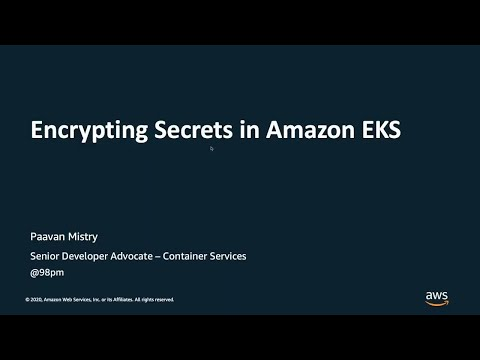

In [19]:
from IPython.display import YouTubeVideo
YouTubeVideo('d21JrnszG7Y')

#### Customer Key Store (CMK stored within AWS CloudHSM) 

<blockquote>For most users, the default AWS KMS key store, which is protected by FIPS 140-2 validated cryptographic modules, fulfills their security requirements. 

However, you might consider creating a custom key store if your organisation has any of the following requirements 

* The key material cannot be stored in a shared environment 
* The key material must be backed up in multiple AWS Regions 
* The key material must be subject to a secondary, independent audit path 
* The hardware security module (HSM) that generates and stores key material must be certified at FIPS 140-2 Level 3 

If any of these apply then its worth considering AWS CloudHSM with AWS KMS to create a custom key store. 

## Pre-requisite

* Check your variables are loaded

In [ ]:
%store

* Load in variable store

In [ ]:
%store -r 

* Load variables into notebook

In [ ]:
%env AWS_PROFILE=$AWS_PROFILE
%env AWS_DEFAULT_REGION=$AWS_DEFAULT_REGION
%env ACCOUNT_ID=$ACCOUNT_ID

* Check identity 

In [ ]:
!aws sts get-caller-identity

<br>

---
---

## <br><br> Create a Secret 

* Create a namespace for this exercise

In [ ]:
!kubectl create ns secretslab

* Create a text file containing your secret 

In [ ]:
!echo "Visit Adnan.Study for Adnan's techie Notes! " > temp/test-creds

* Create your secret

In [ ]:
%%bash 

kubectl create secret \
         generic test-creds \
         --from-file=test-creds=temp/test-creds \
         --namespace secretslab

* Retrieve the secret via the CLI 

In [ ]:
!kubectl get secret test-creds -o jsonpath="{.data.test-creds}" --namespace secretslab | base64 --decode

<br><br>At the end of this lab, we will validate the Decrypt API call in CloudTrail. 

It will take some time for the event to be viewable in CloudTrail. 

For now lets attempt retrieve the secret using a pod

## <br><br> Access the Secret from a Pod 

* Deploy a Pod to Consume the Secret 

In [ ]:
!cat secrets/podconsumingsecret.yaml

In [ ]:
!kubectl --namespace secretslab apply -f secrets/podconsumingsecret.yaml

* Attach to the pod and attempt to access the secret

In [ ]:
!kubectl --namespace secretslab exec -it consumesecret -- cat /tmp/test-creds

* Check Cloudtrail to see the decryption via KMS

In [ ]:
!aws cloudtrail lookup-events --lookup-attributes AttributeKey=EventName,AttributeValue=Decrypt --max-items=1 --region eu-west-1